In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import re
import time

# Data input

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
calendar_dates = pd.read_csv('/content/drive/MyDrive/hach-my-ride/gtfs3Sept/calendar.txt')
routes = pd.read_csv('/content/drive/MyDrive/hach-my-ride/gtfs3Sept/routes.txt')
stops = pd.read_csv('/content/drive/MyDrive/hach-my-ride/gtfs3Sept/stops.txt')
stop_times = pd.read_csv('/content/drive/MyDrive/hach-my-ride/gtfs3Sept/stop_times.txt')
trips = pd.read_csv('/content/drive/MyDrive/hach-my-ride/gtfs3Sept/trips.txt')

In [ ]:
vehicle_positions = pd.read_csv('/content/drive/MyDrive/hach-my-ride/vehiclePositionsTime.csv')

In [ ]:
# # timestamp -> date, hour, day
# # USE ONLY ONCE IF YOU NEED TO GENERATE THE COLUMNS FROM THE BASE FILE VEHICLEPOSITOISN

# weekdays = ['Monday','Tuesday','Wednesday', 'Thursday','Friday']

# vehicle_positions['date'] = pd.to_datetime(vehicle_positions['Timestamp'], unit='ms')#.dt.strftime("%Y%m%d").astype(int)
# vehicle_positions['hour'] = pd.to_datetime(vehicle_positions['Timestamp'], unit='ms')#.dt.strftime("%H:%M:%S")
# vehicle_positions['day'] = pd.to_datetime(vehicle_positions['Timestamp'], unit='ms')#.dt.strftime("%A") \
#                     # .apply(lambda x: 0 if x in weekdays else 1 if x=='Saturday' else 2 if x=='Sunday' else 3)
# vehicle_positions['date'] = vehicle_positions['date'].dt.strftime("%Y%m%d").astype(int)
# vehicle_positions['hour'] = vehicle_positions['hour'].dt.strftime("%H:%M:%S")
# vehicle_positions['day'] = vehicle_positions['day'].dt.strftime("%A") \
#                     .apply(lambda x: 0 if x in weekdays else 1 if x=='Saturday' else 2 if x=='Sunday' else 3)

# vehicle_positions.to_csv('./vehiclePositionsTime.csv',mode='w', index=False)


# Utility Functions

In [3]:
# some functions we use
def get_sec(time_str):
    """Get Seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [4]:
def get_hhmmss(seconds: int):
  return time.strftime('%H:%M:%S', time.gmtime(seconds))


# Data Prep

**Possible problems:**
- Some lanes have different route_short_name. I think there is a line 1 and a M1, but they are the same line. Also, there are tram lines that have T## and others that don't have the T, like 93, 92
- Departure and arrival times are the same. We can ommit one column
    stop_times['arrival_time'].equals(stop_times['departure_time'])
- The timestamp format is including miliseconds which give error (54061 year). we can remove the last 3 digitis which are the miliseconds

## Cleaning the stops from letters and padding the zeros. 
DOES NOT AFFECT THE STOPS, JUST MAKES THEM INTEGERS

You can use .copy() in order to create a new variable, this way we only reference them.

In [ ]:
stops_cleaned = stops # remove the .copy() if you want the change to be made in stops, or do it directly there
stops_cleaned['stop_id'] = stops_cleaned['stop_id'].map(lambda x: int(re.sub('[^0-9]', '', x))) # clean the letters and zeros
stops_cleaned.drop_duplicates(subset=['stop_id'], keep='first') # remove the duplicates
# stops_cleaned.to_csv('/content/drive/MyDrive/hach-my-ride/gtfs3Sept/stops_cleaned.csv') 

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,89,NaN,MONTGOMERY,NaN,50.838006,4.408970,NaN,NaN,0,37.0
1,470,NaN,SIMONIS,NaN,50.863666,4.329612,NaN,NaN,0,NaN
2,471,NaN,SIMONIS,NaN,50.863732,4.329236,NaN,NaN,0,53.0
3,472,NaN,SIMONIS,NaN,50.863543,4.329023,NaN,NaN,0,53.0
4,473,NaN,SIMONIS,NaN,50.863418,4.330031,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...
2993,34,NaN,TOMBERG,NaN,50.844316,4.425819,NaN,NaN,1,NaN
2994,44,NaN,TRONE,NaN,50.840813,4.366354,NaN,NaN,1,NaN
2995,32,NaN,VANDERVELDE,NaN,50.847387,4.446705,NaN,NaN,1,NaN
2996,6,NaN,VEEWEYDE,NaN,50.829391,4.300578,NaN,NaN,1,NaN


In [ ]:
stop_times_cleaned = stop_times # remove the .copy() if you want the change to be made in stops, or do it directly in the stops var
stop_times_cleaned['stop_id'] = stop_times_cleaned['stop_id'].map(lambda x: int(re.sub('[^0-9]', '', str(x)))) # clean the letters and zeros
stop_times_cleaned.drop_duplicates(subset=['stop_id'], keep='first') # remove the duplicates
# stop_times_cleaned.to_csv('/content/drive/MyDrive/hach-my-ride/gtfs3Sept/stop_times_cleaned.csv') 


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
0,112387248235954071,21:07:00,21:07:00,4014,1,0,0
1,112387248235954071,21:09:00,21:09:00,3231,2,0,0
2,112387248235954071,21:10:08,21:10:08,3232,3,0,0
3,112387248235954071,21:11:00,21:11:00,3233,4,0,0
4,112387248235954071,21:11:43,21:11:43,3239,5,0,0
...,...,...,...,...,...,...,...
2738300,113320223237474503,24:42:42,24:42:42,5063,15,0,0
2739146,113320253237474503,06:03:46,06:03:46,5021,22,0,0
2739147,113320253237474503,06:04:48,06:04:48,5022,23,0,0
2760589,113141678236809000,06:01:00,06:01:00,2878,12,0,0


## Transforming the static data into one variable -> trips_merged

In [ ]:
# transform calendar_dates
# this way we only store one value because the calendar dates repeat
# it is also done in the rest of the project
# 0 - weekday, 1, saturday, 2 sunday, 3 else/
calendar = pd.read_csv('/content/drive/MyDrive/hach-my-ride/gtfs3Sept/calendar.txt')
calendar['day'] = calendar.apply(lambda x: 0 if x.monday==1 else 1 if x.saturday==1 else 2 if x.sunday==1 else 3 , axis=1)
calendar.drop(['monday','tuesday','wednesday','thursday','friday','saturday','sunday'], axis=1, inplace=True)
# calendar


In [ ]:
# make the big join, we have all the needed information
# del trips_merged
routes = routes[['route_id','route_short_name']]
stops = stops[['stop_id','stop_name']]
trips = trips[['route_id','service_id','trip_id','trip_headsign','direction_id']]
stop_times = stop_times[['trip_id','arrival_time','stop_id','stop_sequence']]
trips_merged = trips.merge(stop_times, on='trip_id', how='inner')\
                    .merge(calendar, on='service_id', how='inner')\
                    .merge(stops, on='stop_id', how='inner')\
                    .merge(routes, on='route_id', how='inner')


## Generate data (lineXX, vehicleXX) for a certain line number

In [ ]:
def getLineAndVehicle(line_number: int):
    line = trips_merged[trips_merged['route_short_name'] == str(line_number)]
    vehicle = vehicle_positions[vehicle_positions['LineId'] == line_number]
    return line, vehicle

In [ ]:
def getStopName(stop_number: str):
    for k,v in stops_dictionary.items():
        if(stop_number in v):
            return k

In [ ]:
def matchTimeWithStops(line, vehicle_timestamp):
    return line.loc[(line['stop_id'].values == vehicle_timestamp.PointId) & \
                (line['start_date'].values <= vehicle_timestamp.date) & \
                (line['end_date'].values >= vehicle_timestamp.date) & \
                (line['day'].values == vehicle_timestamp.day)]


In [ ]:
def calculateTheDelay(delays, vehicle_row):
    def f(x, vehicle_row):
      return get_sec(vehicle_row) - get_sec(x)

    fvec = np.vectorize(f)  # or use a different name if you want to keep the original f

    result_array = fvec(delays.arrival_time, vehicle_row.hour)  # if A is your Numpy array
    argmin = np.abs(result_array).argmin()
    return result_array[argmin]

In [ ]:
def filterVehicles(vehicles):
  first_vehicle = line.arrival_time.min()
  last_vehicle = line.arrival_time.max() # could be > '24:00:00'

  # dropping by earliest vehicles (also removes the after midnight busses)
  # we give a window of 1 minute if it leaves earlier 
  vehicles.drop(vehicles.loc[(vehicles['hour'].values <= get_hhmmss(get_sec(first_vehicle) - 60))].index, inplace=True)

  # dropping busses after the last vehicle
  # It is optional because if it's past midnight it is dropped by the previous drop
  if(last_vehicle < '24:00:00'):
    vehicles.drop(vehicles.loc[(vehicles['hour'].values >= last_vehicle)].index, inplace=True)
  
  vehicles.drop(vehicles.loc[(vehicles['DistanceFromPoint'].values != 0)].index, inplace=True)

In [ ]:
# If delays is empty (ex with bus 95) we get: ValueError: Columns must be same length as key
# Da vidam kako ke rabotam so tie sto ne mi davaat vrednost
# Da smislam kako ke gi zacuvam delovite. dali ke gi stavam kako kolona

line_numbers = vehicle_positions.LineId.unique()

for number in line_numbers[25:]:
    line, vehicles = getLineAndVehicle(number)
    filterVehicles(vehicles)
    print(f"LINE{number}")
    total_delays = []
    total_arrival_time = []
    
    for index, vehicle_row in vehicles.iterrows(): # go through each bus that is on the stop
        delays = matchTimeWithStops(line, vehicle_row) # get the delays from the matched possible stoptimes for that vehicle in that line

        if delays.empty != True: # avoid when it doesn't find anything
            # print(f"line{number} {index} size: {line.size}, possible matches: {delays.size}")
            final_delay = calculateTheDelay(delays, vehicle_row)
            # print(f"for timestamp: {final_delay}")
            total_delays.append(final_delay)
        else:
            total_delays.append(None)
        
    vehicles['delay'] = total_delays
    vehicles.to_csv(f'/content/drive/MyDrive/hach-my-ride/delays2/vehicleDelaysLine{number}.csv',mode='w', index=False)
    # break

# Cleaning the delays


In [6]:
# d1 = pd.read_csv('/content/drive/MyDrive/hach-my-ride/delays/vehicleDelays.csv')
delays_uncleaned = pd.read_csv('/content/drive/MyDrive/hach-my-ride/delays2/vehicleDelays.csv')
delays = delays_uncleaned.dropna(subset=['delay'])

In [ ]:
# How many vp did we lost in total?
delay_nulls = delays_uncleaned.delay.isnull().sum(axis = 0)
delay_size = delays_uncleaned.delay.size

# TODO: check if this is okay stats
print(f"The number of null values:\t{delay_nulls}")
print(f"The number of total values:\t{delay_size}")
print(f"Percentage of null values:\t{delay_nulls / delay_size * 100}")

The number of null values:	1216547
The number of total values:	6416423
Percentage of null values:	18.959894009481605


Lines with the smallest number of dropped rows
LineId
92    16.075647
28    16.851053
56    17.273302
33    17.309073
46    17.384483
Name: delay, dtype: float64
Lines with the highest number of dropped rows
LineId
59     31.110529
48     36.063127
95     74.109571
70     85.121092
37    127.620014
Name: delay, dtype: float64
Average number of rows dropped by ever line 24.2899758249539 %


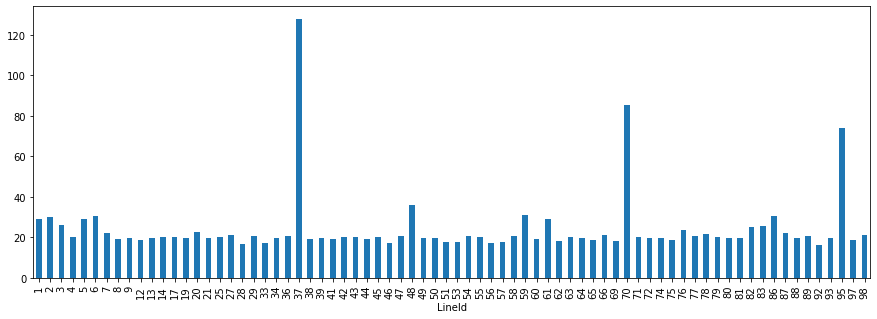

In [ ]:
# How many vp did we last for every line in total
dropped_rows_by_line = delays_uncleaned.groupby(['LineId'])['delay'].agg(lambda x: x.isnull().sum() / x.count() *100)
dropped_rows_by_line.plot(kind='bar', figsize=(15,5))
dropped_rows_by_line = dropped_rows_by_line.sort_values()

print("Lines with the smallest number of dropped rows")
print(dropped_rows_by_line.head())

print("Lines with the highest number of dropped rows")
print(dropped_rows_by_line.tail())

print(f"Average number of rows dropped by ever line {dropped_rows_by_line.mean()} %")

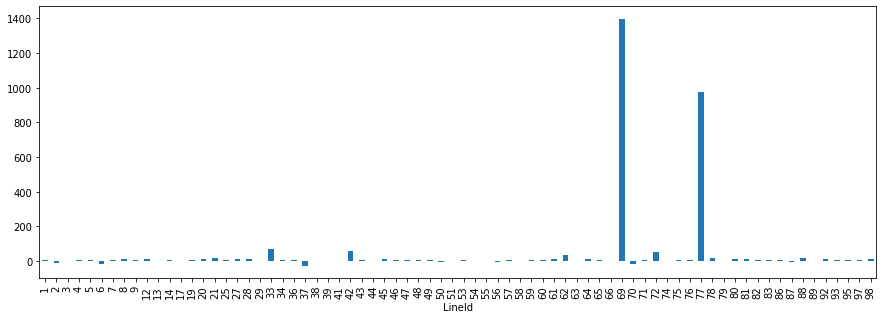

In [57]:
# CHECK THE OUTLIERS

# remove the medians 69, 77
# work on 42
#
delays.groupby('LineId')['delay'].median().plot(kind='bar', figsize=(15,5))
# from the median table we can drop line 69 and 77

In [7]:
delays.drop(delays.loc[delays['LineId'] == 69].index, inplace=True)
delays.drop(delays.loc[delays['LineId'] == 77].index, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


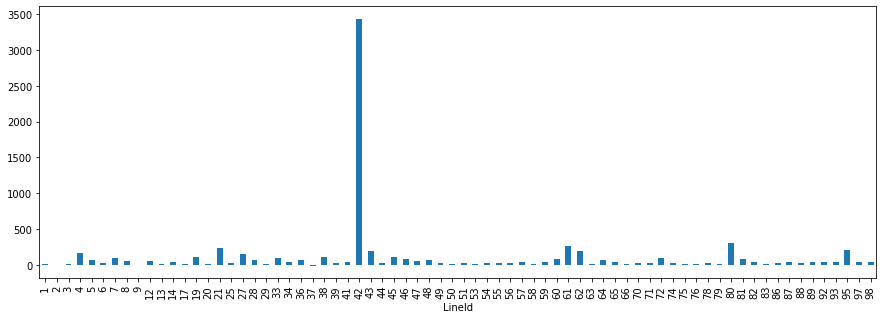

In [ ]:
delays.groupby('LineId')['delay'].mean().plot(kind='bar', figsize=(15,5))

In [8]:
def filterByIntervalDelay(delays, mindelay: int, maxdelay: int):
  delays.drop(delays.loc[(delays['delay'].values > maxdelay)].index, inplace=True)
  delays.drop(delays.loc[(delays['delay'].values < mindelay)].index, inplace=True)

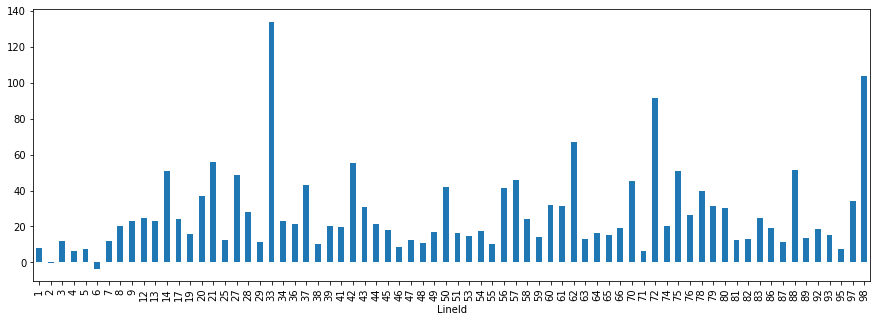

In [ ]:
delays.groupby('LineId')['delay'].mean().plot(kind='bar', figsize=(15,5))

In [9]:
filterByIntervalDelay(delays, -300, 720)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Delays by stop

In [ ]:
# stops that have the biggest delay
delay_by_stop = delays.groupby('PointId')['delay'].mean()
delay_by_stop = delay_by_stop.sort_values()
delay_by_stop.tail()

PointId
2582     7244.000000
5458    12216.000000
5480    12759.553846
1531    27858.054674
2904    31561.200000
Name: delay, dtype: float64

In [ ]:
# stop that are very early
delay_by_stop.head()

PointId
8732   -392.662787
1958   -345.000000
1008   -223.000000
2478   -218.800000
3529   -149.181818
Name: delay, dtype: float64

In [ ]:
# stops that are the closest to be on time
delay_by_stop[delay_by_stop.abs().sort_values().head(10).index]

PointId
5062     1.000000
8081     1.628109
2892     4.344828
8132    -5.202256
8142     7.223628
4299    -7.295302
9635    10.000000
4455    10.056338
6368    13.828767
8102    17.073200
Name: delay, dtype: float64

In [ ]:
# line that has the biggest delay
delay_by_line = delays.groupby('LineId')['delay'].mean()
delay_by_line = delay_by_line.sort_values()
delay_by_line.tail()

LineId
61    1256.180177
80    1314.079215
77    2864.170427
69    2986.620938
42    6115.813631
Name: delay, dtype: float64

In [ ]:
# line that is early
delay_by_line.head()

LineId
1      -5.119148
66    143.585800
63    157.287312
83    162.936478
71    168.820725
Name: delay, dtype: float64

In [ ]:
# line that is most on time
delay_by_line[delay_by_line.abs().sort_values().head(5).index]

LineId
1      -5.119148
66    143.585800
63    157.287312
83    162.936478
71    168.820725
Name: delay, dtype: float64

In [ ]:
# for each line get distribution how late they are. see if they are more on the left right
# get which ones are me late/less late


# stops[stops.stop_id.isin(delays_stops.get(1))]

# delays.groupby(['LineId', 'PointId'])['delay'].mean()
# stops
delays_with_stop_names = delays.merge(stops, how='inner', left_on='PointId', right_on='stop_id')
delays_with_stop_names.groupby(['LineId', 'stop_name'], sort=False)['delay'].mean().get(1)
# df.iloc[df.prod(1).argsort()]
# delays.iloc[
# delays_stops.
# df.loc[df['column_name'].isin(some_values)]
# delays_stops.get(1)
# delays_with_stop_names

delays_stops = delays.groupby('LineId')['PointId'].unique()
# delays_stops.get(1)
delays_stops

LineId
1     [8142, 8282, 8111, 8281, 8162, 8151, 8733, 874...
2     [8401, 8441, 8743, 8754, 8302, 8472, 8322, 835...
3     [6253, 5701, 6179, 2338, 506, 606, 2537, 5704,...
4     [1985, 4501, 6423, 526, 5920, 705, 5024, 5025,...
5     [8211, 8011, 8262, 8671, 8641, 8261, 8711, 827...
                            ...                        
92    [5315, 6437, 5064, 6413, 6461, 6430, 5029, 693...
93    [5400, 2537, 2543, 6314, 2878, 5405, 5471, 540...
95    [4306, 4351, 3514, 1983, 3558, 2268, 6432, 434...
97    [5120, 5721, 5722, 2336, 2708, 6428, 5723, 575...
98    [5952, 1951, 2384, 2382, 5058, 5922, 9686, 385...
Name: PointId, Length: 74, dtype: object

In [ ]:
# for each line get distribution how late they are. see if they are more on the left right
# get which ones are me late/less late


# stops[stops.stop_id.isin(delays_stops.get(1))]

# delays.groupby(['LineId', 'PointId'])['delay'].mean()
# stops
delays_with_stop_names = delays.merge(stops, how='inner', left_on='PointId', right_on='stop_id')
delays_with_stop_names.groupby(['LineId', 'stop_name'], sort=False)['delay'].mean().get(1)
# df.iloc[df.prod(1).argsort()]
# delays.iloc[
# delays_stops.
# df.loc[df['column_name'].isin(some_values)]
# delays_stops.get(1)
# delays_with_stop_names

delays_stops = delays.groupby('LineId')['PointId'].unique()
# delays_stops.get(1)
delays_stops

LineId
1     [8142, 8282, 8111, 8281, 8162, 8151, 8733, 874...
2     [8401, 8441, 8743, 8754, 8302, 8472, 8322, 835...
3     [6253, 5701, 6179, 2338, 506, 606, 2537, 5704,...
4     [1985, 4501, 6423, 526, 5920, 705, 5024, 5025,...
5     [8211, 8011, 8262, 8671, 8641, 8261, 8711, 827...
                            ...                        
92    [5315, 6437, 5064, 6413, 6461, 6430, 5029, 693...
93    [5400, 2537, 2543, 6314, 2878, 5405, 5471, 540...
95    [4306, 4351, 3514, 1983, 3558, 2268, 6432, 434...
97    [5120, 5721, 5722, 2336, 2708, 6428, 5723, 575...
98    [5952, 1951, 2384, 2382, 5058, 5922, 9686, 385...
Name: PointId, Length: 74, dtype: object

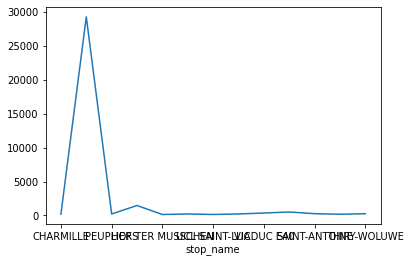

In [ ]:
# for each line get distribution how late they are. see if they are more on the left right
# get which ones are me late/less late

# TODO: find a way to get all the lines from beginning to terminus and sort the data like that.
# This way we will have a representation how the delay can grow/decrease after each station
# Or maybe there is no need for that because every time we have a different direction

delays_with_stop_names = delays.merge(stops, how='inner', left_on='PointId', right_on='stop_id')
l1 = delays_with_stop_names.groupby(['LineId','stop_name'], sort=False)['delay'].mean().get(42)

l1.plot()

# Delays through time

In [ ]:
def get_hour(hour_str: str):
  return int(hour_str.split(':')[0])

In [ ]:
# creating the hour_interval column to know in which hour is the delay
delays['hour_interval'] = delays['hour'].apply(lambda x: get_hour(x))

In [ ]:
delays.hour_interval.values

In [ ]:
delays_with_stop_names.interval.value_counts()

3    1713995
4    1124644
2     980313
5     715243
1     668605
0     350798
6     303017
Name: interval, dtype: int64

In [ ]:
# What point of the day do we have the biggest delays

# XXX: here we notice that in the morning they are super super slow
# ISSUE: We get None for the night (if we use 1AM)

delays_with_stop_names.groupby('interval')['delay'].mean()

interval
0    5919.427172
1     507.623769
2      88.618672
3      60.165338
4      32.115012
5      22.934435
6      14.131514
Name: delay, dtype: float64

In [ ]:
# Get which line is slow at what point of the day
delays_with_stop_names.groupby(['LineId', 'interval'])['delay'].median()

LineId  interval
1       0            -34.0
        1            -30.0
        2            -32.0
        3            -33.0
        4            -32.0
                     ...  
98      2             -8.5
        3             -9.0
        4              3.0
        5             63.0
        6          -1214.5
Name: delay, Length: 507, dtype: float64

In [ ]:
# Get the delays for each stop at different point of day
delays_with_stop_names.groupby(['stop_name', 'interval'])['delay'].mean()

stop_name  interval
ABBAYE     0           4901.848837
           1            356.206897
           2             -8.754762
           3             -4.750000
           4             -0.694497
                          ...     
ZEPHYR     2            -22.641791
           3            -51.625000
           4            -35.806452
           5            -12.090909
           6            191.142857
Name: delay, Length: 6030, dtype: float64

In [ ]:
# Get the delays for each stop for a single line at different point of day

In [ ]:
# Foreach interval get the stop that is the busiest
delays_with_stop_names.groupby(['interval','stop_name'])['delay'].mean()

interval  stop_name        
0         ABBAYE               4901.848837
          ACACIAS              2671.000000
          AERODROME            3639.608696
          ALBERT               9767.059359
          ALBERT I             3934.085774
                                  ...     
6         YSER                 -851.256949
          ZAMAN-FOREST NAT.     -42.568000
          ZAVELPUT               28.512195
          ZEECRABBE             -57.333333
          ZEPHYR                191.142857
Name: delay, Length: 6030, dtype: float64

In [ ]:
delays_with_stop_names.groupby(['stop_name', 'interval'])['delay'].mean()

In [ ]:
# Map how it gradually goes up and down for each hour

In [ ]:
delays

In [ ]:
delays_with_stop_names['delay'] = delays_with_stop_names['delay'].astype(int)

In [ ]:
dd = delays_with_stop_names[(delays_with_stop_names['delay'] <= 900) & (delays_with_stop_names['delay'] > -900)]

In [ ]:
a = dd.groupby(['interval','LineId'])['delay'].mean()

# Export data

In [ ]:
delays.drop(columns=['DistanceFromPoint'], axis=1, inplace=True)
delays.columns = ['Timestamp', 'LineId', 'TerminusStop', 'CurrentStop', 'Date','Hour','Day','Delay']
delays['Delay'] = delays['Delay'].astype(int)
delays['ExpectedArrivalTime'] = [ get_hhmmss(get_sec(x) + y) for x, y in zip(delays['Hour'], delays['Delay'])]
delays['Delay'] = delays['Delay'] * -1


38686256

In [18]:
delays.to_csv('/content/drive/MyDrive/hach-my-ride/delaysNoDuplicates.csv', index=False)

In [113]:
pd.set_option("display.max_rows", None)
delays.head(3)

,Timestamp,LineId,TerminusStop,CurrentStop,Date,Hour,Day,Delay,ExpectedArrivalTime
0,1630914886924,12,9600,9600,20210906,07:54:46,0,286,07:50:00
1,1630914886924,12,1780,9600,20210906,07:54:46,0,286,07:50:00
2,1630914886924,12,9600,1780,20210906,07:54:46,0,-14,07:55:00


In [16]:
delays.drop_duplicates(keep='first', inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
d1 = delays.copy()
d2 = delays.copy()

In [ ]:
# delays_first = d1.drop_duplicates(subset=['LineId','Date','Day','TerminusStop','CurrentStop','ExpectedArrivalTime'], keep='first')
final_filtered_delays[final_filtered_delays['LineId'] == 17].groupby(['LineId','Date','Day','TerminusStop','CurrentStop','ExpectedArrivalTime'])['Delay'].agg(list)
# delays_first.to_csv('/content/drive/MyDrive/hach-my-ride/delays_first.csv', index=False)

In [110]:
line_numbers = delays.LineId.unique()
drop_condition = ['LineId','Date','Day','TerminusStop','CurrentStop','ExpectedArrivalTime']

all_delays = []

for line in line_numbers:
  # print(delays_first[delays_first['LineId'] == line].Delay.shape)
  start_stops = np.unique(delays[delays['LineId'] == line]['TerminusStop'].values)

  start_delays = delays.loc[(delays["LineId"] == line) & \
                            (delays['TerminusStop'] != delays['CurrentStop']) & \
                            (delays['CurrentStop'].isin(start_stops))]
  start_delays = start_delays.drop_duplicates(subset=drop_condition, keep='last')
  # print(start_delays.Delay.size)

  regular_delays = delays.loc[(delays['LineId'] == line) & \
                              ~(delays['CurrentStop'].isin(start_stops))]

  regular_delays = regular_delays.drop_duplicates(subset=drop_condition, keep='first')

  # print(regular_delays.Delay.size)
  terminus_delays = delays.loc[(delays['LineId'] == line) & \
                               (delays['TerminusStop'] == delays['CurrentStop'])]

  terminus_delays = terminus_delays.drop_duplicates(subset=drop_condition, keep='first')

  # print(terminus_delays.Delay.size)

  df_concat = pd.concat([start_delays.reset_index(drop=True),\
                         regular_delays.reset_index(drop=True),\
                         terminus_delays.reset_index(drop=True)])
  
  all_delays.append(df_concat.reset_index(drop=True))


final_filtered_delays = pd.concat(all_delays)

In [115]:
final_filtered_delays.to_csv('/content/drive/MyDrive/hach-my-ride/final_filtered_delays.csv', index=False)

In [72]:
# pd.reset_option('^display.', silent=True)
st = np.unique(final_filtered_delays[final_filtered_delays['LineId'] == 17]['TerminusStop'].values)
k = final_filtered_delays.loc[(final_filtered_delays['LineId'] == 17) & ~(final_filtered_delays['CurrentStop'].isin(st))]
k.loc[k['TerminusStop'] != k['CurrentStop']]

,Timestamp,LineId,TerminusStop,CurrentStop,Date,Hour,Day,Delay,ExpectedArrivalTime
147385,1630914978881,17,9059,4342,20210906,07:56:18,0,202,07:52:56
147393,1630915234479,17,9059,1472,20210906,08:00:34,0,137,07:58:17
147394,1630915268784,17,9059,1472,20210906,08:01:08,0,171,07:58:17
147395,1630915300426,17,9059,1472,20210906,08:01:40,0,203,07:58:17
147396,1630915334425,17,9059,1472,20210906,08:02:14,0,237,07:58:17
...,...,...,...,...,...,...,...,...,...
172280,1632002133581,17,4297,4351,20210918,21:55:33,1,273,21:51:00
172281,1632002228201,17,4297,4348,20210918,21:57:08,1,273,21:52:35
172311,1632003812193,17,9059,1453,20210918,22:23:32,1,-536,22:32:28
172317,1632004628534,17,9059,4289,20210918,22:37:08,1,47,22:36:21


In [109]:
d17 = delays[delays['LineId'] == 17]#.sort_values(by=['Date', 'CurrentStop', 'ExpectedArrivalTime'])
d17.head(1)

,Timestamp,LineId,TerminusStop,CurrentStop,Date,Hour,Day,Delay,ExpectedArrivalTime
245977,1630914886924,17,9059,4297,20210906,07:54:46,0,-46.0,07:55:32


In [ ]:
d17.groupby(['Date','Day','TerminusStop','CurrentStop','ExpectedArrivalTime'])['Delay'].apply(list)

# Interesting things

In [ ]:
# if we inner join the stations we will loose like 213049 timestamps because 7104 is missing
# TODO: check how right join will work, or maybe get terminus and add the stops
vehicle['DirectionId'].value_counts()

3522    28601
5407    13075
3520      311
6468      260
Name: DirectionId, dtype: int64

In [ ]:
# the progression of busses being close to a station 
[len(vehicle[vehicle['DistanceFromPoint'].apply(lambda x: x<=i)]) for i in range(20)]



[10426,
 10506,
 10581,
 10629,
 10685,
 10736,
 10777,
 10815,
 10853,
 10886,
 10904,
 10943,
 10971,
 10998,
 11016,
 11034,
 11046,
 11075,
 11093,
 11111]

In [ ]:
d = pd.from_csv('/content/drive/MyDrive/hach-my-ride/delays.csv')